## Harnessing instrument simulators for model evaluation

In this 45 minute lecture, we will cover the basics of how to evaluate model simulations using instrument simulators. This course covers:

    1. The basic principles of instrument simulators for models
    2. Examining E3SM single column model data using xarray
    3. Using the Earth Model Column Collaboratory to create simulated radar moments for evaluation
    4. Loading ARM KAZR data at COMBLE for comparison against model simulated radar moments


## Instrument simulators

Models do not typically output parameters that are directly comparable to atmospheric measurements. This complicates the evaluation of model performance using atmospheric observations, which are typically the only metric available for assessing the performance of such simulations. In order to assess how well a model simulation represents the target atmospheric phenomena -- whether it be convection, cloud cover, or aerosols, instrument simulators provide a key bridge between the measurements and model simulations. They do this by simulating the instrument output from within the model simulation. 

## How do instrument simulators work?

This section, in particular, will focus on how instrument simulators for instruments designed to detect clouds and precipitation such as radars and lidars.

Bulk cloud microphysics parameterizationst will typically predict either one or two moments of the hydrometeor size distribution $N(D)$. The "classic" Morrison-Gettleman scheme will predict these two moments (usually number concentration $N$ and mass mixing ratio $Q$) for four hydrometeor categories: cloud liquid (cl), cloud ice (ci), precipitating liquid (pl), and precipitating ice (pi) [1]. However, $N$ and $Q$ are not measured by radars and lidars. Instead, radar and lidars first emit a beam of microwave (radar) or near-infrared (lidar) radiation. They then measure the in-phase and quadrature signals of the signal recieved by the transciever that recieves the backscattered signal from the hydrometers in the sample volume. These signals are then converted into Doppler spectra, then subsequently converted into momemts such as radar reflectivity factor $Z_{e}$ and radial velocity $v_{d}$.

The method by which we then have to create an apples-to-apples comparison of the model simulated cloud properties against those observed by the radar is to simulate the radar inside the model simulation. This is done by taking in the assumptions made by the model's radiative transfer scheme with regards to forward scattering. For example, to calculate the reflectivity using Equation (1), we need to know the backscattering cross section of the hydrometeor $\beta_{hyd}$, the wavelength of the radar $\lambda$ and the dielectric constant of the scattering medium (ice or water) $K_{w}$. Then, once we know these, which are all inputs either assumed by the model or are a property of the instrument we are simulating, can calculate $Z_{e}$ as $$Z_{e, hyd} = \frac{\beta_{hyd} \lambda^{4}}{\pi^{5}K_{w}^2}$$

In this section of the course, we will utilize the [Earth Column Model Collaboratory (EMC^2)](https://github.com/columncolab/EMC2) to simulate the Ka-band Scanning Zenith Radar (KAZR) inside a DHARMA LES simulation. EMC^2 is an open source framework that will provide simulated radar moments from single column model (SCM) simulations, utilizing a sub-column generator to generate a distribution of realizations of the SCM column according to the model cloud fraction. This takes into account the potential uncertainty due to a vertically pointing radar only capturing a fraction of the SCM column. The simulated radar or lidar moments from the subcolumns can then be compared against the observed moments from the instrument. For more information on both the calculation of the simulated moments and sub-column generation, see [2].

In addition, EMC^2 has an LES mode where the model subcolumns are mapped directly to the x and y coordinates of the LES simulation. For this tutorial, we will focus on the LES simulations from DHARMA for a case observed during COMBLE.


References

1. Morrison, H., J. A. Milbrandt, G. Bryan, K. Ikeda, S. A. Tessendorf, and G. Thompson, 2015: Parameterization of cloud microphysics based on the prediction of bulk ice particle properties. Part II: Case study comparisons with observations and other schemes. J. Atmos. Sci., 72, 312–339, https://doi.org/10.1175/JAS-D-14-0066.1.

2. Silber, I., Jackson, R. C., Fridlind, A. M., Ackerman, A. S., Collis, S., Verlinde, J., and Ding, J.: The Earth Model Column Collaboratory (EMC2) v1.1: an open-source ground-based lidar and radar instrument simulator and subcolumn generator for large-scale models, Geosci. Model Dev., 15, 901–927, https://doi.org/10.5194/gmd-15-901-2022, 2022. 


In [3]:
# For OLCF JupyterHub only
import os
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
import xarray as xr
import emc2
import numpy as np
import matplotlib.pyplot as plt
import radtraq

from dask.distributed import LocalCluster, Client
%matplotlib inline

## Preview DHARMA simulation

In [4]:
ds = xr.open_dataset('/data/project/ARM_Summer_School_2024_Data/emc2/emc2_prep.nc')
ds

<xarray.Dataset> Size: 959MB
Dimensions:         (x: 256, y: 256, hgt: 159)
Coordinates:
  * x               (x) float64 2kB -1.275e+04 -1.265e+04 ... 1.275e+04
  * y               (y) float64 2kB -1.275e+04 -1.265e+04 ... 1.275e+04
  * hgt             (hgt) float32 636B 10.0 32.5 60.0 ... 6.92e+03 6.975e+03
Data variables: (12/23)
    z               (hgt, x, y) float32 42MB ...
    u_wind          (hgt, x, y) float32 42MB ...
    v_wind          (hgt, x, y) float32 42MB ...
    w_wind          (hgt, x, y) float32 42MB ...
    qcl             (hgt, x, y) float32 42MB ...
    qci             (hgt, x, y) float32 42MB ...
    ...              ...
    strat_cl_frac   (hgt, x, y) float32 42MB ...
    strat_ci_frac   (hgt, x, y) float32 42MB ...
    strat_pl_frac   (hgt, x, y) float32 42MB ...
    strat_pi_frac   (hgt, x, y) float32 42MB ...
    strat_pir_frac  (hgt, x, y) float32 42MB ...
    conv_dat        (hgt, x, y) float32 42MB ...

## Subsetting the data

Running EMC^2 over the entire simulation domain at once is computationally expensive. Therefore, we will subset the domain to include an along-wind track along the region of interest. In this case, we will select the region of interest to be where the highest precipitation ice mixing ratios are near the surface, indicating the heaviest precipitation bands in the simulation domain.

First, let us obtain the mean wind direction below 1 km.

In [ ]:
u_mean = ds.u_wind.where(ds.z < 1000).mean()
v_mean = ds.v_wind.where(ds.z < 1000).mean()
v_mean

Then, we create a line whose slope is along the mean wind direction and goes through a point ($x_{0}$, $y_{0}$). We select the ($x_{0}$, $y_{0}$) = (-4 km, -3 km), since at this point in the domain the ice precipitation mixing ratio near the surface is the highest.

In [ ]:
slope = v_mean/u_mean
x0 = -4400
y0 = -3000
y_line = slope * (ds.x - x0) + y0 
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ds["qpi"].T.isel(hgt=2).plot(ax=ax)
ax.plot(ds.x, y_line)

# Earth Model Column Collaboratory

The Earth Model Column Collaboratory (EMC^2) is an open source Python instrument simulator that implements a Model class that contains the scattering characteristics of the hydrometeor species assumed by the model as well as the list of model variables that are needed to generate the simulated instrument parameters. In addition, EMC^2 has an Instrument class that stores the necessary characteristics for each instrument. Currently, EMC^2 only supports vertically pointing radars and lidars.

These two classes are then inputs to a subcolumn generator that will, in the case of general circulation model grid cells, simulate the sub-grid variability inside the grid cell. This allows for the comparison to account for uncertainties due to model sub-grid cell variability, since the instrument's beamwidth is going to be much smaller than a GCM grid cell. In the case of Large Eddy Scale simulations, EMC^2 will disable this subcolumn generator if the user specifies only one subcolumn. Finally, the generated moments in each subcolumn are used to generate the simulated radar and lidar moments.

<img src = "https://gmd.copernicus.org/articles/15/901/2022/gmd-15-901-2022-f01-web.png" width="400" height="800">

Model sub classes:* E3SM (EAM)* CESM 2 (CAM6)
* ModelE 3* WRF
* DHARMA

Instrument sub-classes:
Radars:* C SAPR* X SACR* Ka SACR* KAZR* WACR* BASTA* NEXRADLidars:* Raman* Micropulse lidar (MPL)* HSRL* Ceilometer* 1064 nm (NIR) lidars* CALIOP (CALIPSO)

# Loading into EMC^2

First, we will use EMC^2's Model structure to load the DHARMA data.

In [5]:
dharma = emc2.core.model.DHARMA('/data/project/ARM_Summer_School_2024_Data/emc2/emc2_prep.nc', single_pi_class=False)

emc2_prep.nc is a regional output dataset; Stacking the time, lat, and lon dims for processing with EMC^2.


Using the subsetting code above, we will modify the `.ds` attribute containing the xarray dataset with the model simulation data. We will store only the along-wind subset of the data inside this attribute. 

We are using a subset for this tutorial to save on computational resources so that the moment generation can complete within the tutorial time limit. We encourage the students to include larger subsets of the domain, building off of this code, to generate their simulated moments to increase the sample size for comparison against observations.

This will help reduce the statistical uncertainty in the comparison.

In [7]:
u_mean = dharma.ds.u_wind.where(dharma.ds.hgt < 1000).mean()
v_mean = dharma.ds.v_wind.where(dharma.ds.hgt < 1000).mean()
slope = v_mean/u_mean
x0 = -4000
y0 = -3000
y_line = slope * (dharma.ds.x - x0) + y0 
dharma.ds["xsection"] = ('time_lat_lon', xr.where(np.isclose(y_line, dharma.ds.y, atol=50), 1, 0))
dharma.ds = dharma.ds.where(dharma.ds["xsection"] == 1).dropna(dim="time_lat_lon")
dharma.ds["distance"] = np.sqrt(
    (dharma.ds["y"] - dharma.ds["y"].values[0])**2 + (dharma.ds["x"] - dharma.ds["x"].values[0]))
dharma.ds = dharma.ds.set_coords(["distance", "hgt"])

As you can see, we have successfully stored the along-wind subset of the data.

In [8]:
dharma.ds

<xarray.Dataset> Size: 3MB
Dimensions:         (time_lat_lon: 107, hgt: 159, y_tmp: 256, x_tmp: 256,
                     dom_col_tmp: 1)
Coordinates:
  * hgt             (hgt) float64 1kB 10.0 32.5 60.0 ... 6.92e+03 6.975e+03
  * y_tmp           (y_tmp) float64 2kB -1.275e+04 -1.265e+04 ... 1.275e+04
  * x_tmp           (x_tmp) float64 2kB -1.275e+04 -1.265e+04 ... 1.275e+04
  * dom_col_tmp     (dom_col_tmp) int64 8B 0
  * time_lat_lon    (time_lat_lon) object 856B MultiIndex
  * y               (time_lat_lon) float64 856B -1.275e+04 ... 1.265e+04
  * x               (time_lat_lon) float64 856B 50.0 -50.0 ... -1.055e+04
  * dom_col         (time_lat_lon) int64 856B 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
    distance        (time_lat_lon) float64 856B 0.0 299.8 ... 2.52e+04 2.54e+04
Data variables: (12/24)
    z               (time_lat_lon, hgt) float64 136kB 10.0 32.5 ... 6.975e+03
    u_wind          (time_lat_lon, hgt) float64 136kB 1.713 1.556 ... 1.544
    v_wind          (time_lat_lon, hgt) float64 136kB -14.37 -14.19 ... -11.19
    w_wind          (time_lat_lon, hgt) float64 136kB 0.0 ... -0.001156
    qcl             (time_lat_lon, hgt) float64 136kB 0.0 0.0 0.0 ... 0.0 0.0
    qci             (time_lat_lon, hgt) float64 136kB 1.409e-07 ... 0.0
    ...              ...
    strat_ci_frac   (time_lat_lon, hgt) float64 136kB 1.0 1.0 1.0 ... 0.0 0.0
    strat_pl_frac   (time_lat_lon, hgt) float64 136kB 0.0 0.0 0.0 ... 0.0 0.0
    strat_pi_frac   (time_lat_lon, hgt) float64 136kB 1.0 1.0 1.0 ... 0.0 0.0
    strat_pir_frac  (time_lat_lon, hgt) float64 136kB 1.0 1.0 1.0 ... 0.0 0.0
    conv_dat        (time_lat_lon, hgt) float64 136kB 0.0 0.0 0.0 ... 0.0 0.0
    xsection        (time_lat_lon) float64 856B 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0

Generating simulated KAZR moments is as easy as these two lines of code. There are two options that EMC^2 supports for generating the simulated moments. 

    * The radiation approach uses lookup tables from the model's radiative transfer schame to calculate the scattering cross sections for quick generation of moments. However, this approach does not generate velocity or spectral width, just reflectivity. T
    * The approach we will use here, the "microphysics approach," explictly integrates the PSD calculated from the model parameters to generate the simulated moments. This takes much more computational resources, but more accurately represents the model microphysics.

In [9]:
KAZR = emc2.core.instruments.KAZR('nsa')
subcols = emc2.simulator.main.make_simulated_data(dharma, KAZR, 1, use_rad_logic=False)

## Creating subcolumns...
No convective processing for DHARMA
num_subcolumns == 1 (subcolumn generator turned off); setting subcolumns frac fields to 1 for startiform cl and ci based on q > 0. kg/kg
Done! total processing time = 0.00s
num_subcolumns == 1 (subcolumn generator turned off); setting subcolumns frac fields to 1 for strat precip based on q > 0. kg/kg
Done! total processing time = 0.00s
num_subcolumns == 1 (subcolumn generator turned off); setting subcolumns q (and N micro logic) fields for cl equal to grid-cell mean
num_subcolumns == 1 (subcolumn generator turned off); setting subcolumns q (and N micro logic) fields for ci equal to grid-cell mean
num_subcolumns == 1 (subcolumn generator turned off); setting subcolumns q (and N micro logic) fields for pl equal to grid-cell mean
num_subcolumns == 1 (subcolumn generator turned off); setting subcolumns q (and N micro logic) fields for pi equal to grid-cell mean
num_subcolumns == 1 (subcolumn generator turned off); setting subcol

## EMC^2 outputs 

The outputs are stored in the `.ds` attribute of `subcols`. The nomenclature of each of the output is as follows:

       'sub_col_Ze_tot_strat': Total reflectivity in stratiform region
       'sub_col_Ze_hyd_strat': Reflectivity of species "hyd" in stratiform region
       'sub_col_Ze_att_tot_strat': Total reflectivity in stratiform region with gaseous attenuation
       'sub_col_Vd_tot_strat': Total radial velocity (w=0) in stratiform region
       'sub_col_Vd_hyd_strat': Radial velocity (w=0) of species "hyd" in stratiform region
       'sub_col_sigma_d_tot_strat': Total spectral width (w=0) in stratiform region
       'sub_col_sigma_d_hyd_strat': Spectral width (w=0) of species "hyd" in stratiform region

Replace 'strat' with 'conv' to have the versions of these outputs in convective regions.
In addition, the subcolumn number concentration (`n`), mixing ratio (`q`) and cloud fraction (`frac`) are stored as `strat_x_subcolumns_hyd` for a given moment `x` and hydrometeor species `hyd`.

In [10]:
subcols.ds

<xarray.Dataset> Size: 9MB
Dimensions:                    (time_lat_lon: 107, hgt: 159, y_tmp: 256,
                                x_tmp: 256, dom_col_tmp: 1, subcolumn: 1)
Coordinates:
  * hgt                        (hgt) float64 1kB 10.0 32.5 ... 6.975e+03
  * y_tmp                      (y_tmp) float64 2kB -1.275e+04 ... 1.275e+04
  * x_tmp                      (x_tmp) float64 2kB -1.275e+04 ... 1.275e+04
  * dom_col_tmp                (dom_col_tmp) int64 8B 0
  * time_lat_lon               (time_lat_lon) object 856B MultiIndex
  * y                          (time_lat_lon) float64 856B -1.275e+04 ... 1.2...
  * x                          (time_lat_lon) float64 856B 50.0 ... -1.055e+04
  * dom_col                    (time_lat_lon) int64 856B 0 0 0 0 0 ... 0 0 0 0 0
    distance                   (time_lat_lon) float64 856B 0.0 ... 2.54e+04
  * subcolumn                  (subcolumn) int64 8B 0
Data variables: (12/67)
    z                          (time_lat_lon, hgt) float64 136kB 10.0 ... 6.9...
    u_wind                     (time_lat_lon, hgt) float64 136kB 1.713 ... 1.544
    v_wind                     (time_lat_lon, hgt) float64 136kB -14.37 ... -...
    w_wind                     (time_lat_lon, hgt) float64 136kB 0.0 ... -0.0...
    qcl                        (time_lat_lon, hgt) float64 136kB 0.0 0.0 ... 0.0
    qci                        (time_lat_lon, hgt) float64 136kB 1.409e-07 .....
    ...                         ...
    atm_ext                    (time_lat_lon, hgt) float64 136kB 1.0 ... 0.97
    sub_col_Ze_att_tot_strat   (subcolumn, time_lat_lon, hgt) float64 136kB 1...
    Ze_min                     (time_lat_lon, hgt) float64 136kB -88.5 ... -3...
    sub_col_Ze_tot             (subcolumn, time_lat_lon, hgt) float64 136kB 1...
    sub_col_Ze_att_tot         (subcolumn, time_lat_lon, hgt) float64 136kB 1...
    detect_mask                (time_lat_lon, hgt, subcolumn) bool 17kB False...

We can visualize the results using standard xarray plotting routines. For this example, we will look at the total reflectivity in the simulation.

Text(0.5, 0, 'Distance [m]')

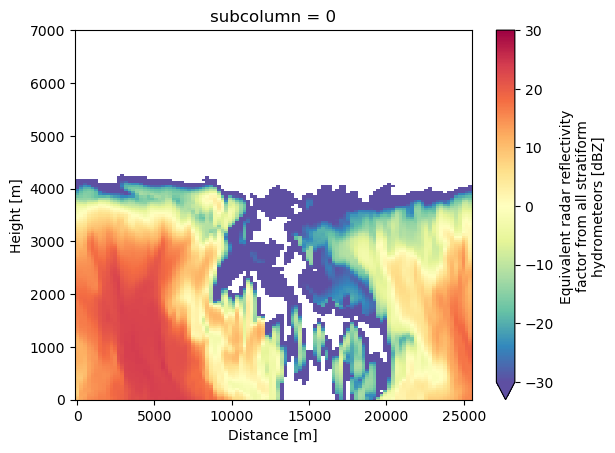

In [11]:
subcols.ds["sub_col_Ze_tot_strat"].sel(subcolumn=0).T.plot(vmin=-30, vmax=30, cmap='Spectral_r', x='distance', y='hgt')
plt.xlabel('Distance [m]')

## Plot Contour Frequency by Altitude Diagram

A common diagram for comparing the statistics from model simulations against observations is a Contour Frequency by Altitude Diagram 
(CFAD) [1]. The CFAD shows how the normalized frequency of values changes with height. For each height level, the frequency histogram is normalized by the number of data points available at each level. Therefore, this takes into account having an uneven number of observations at each height level. 

We use a tool called Radar Tracking of Quality ([RadTraQ](https://github.com/ARM-Development/RadTraQ)), ARM's open source toolkit for Quality Controlling ARM scanning radar data. This toolkit will automatically generate the CFAD values and plots for you with the `radtraq.plotting.calc_cfad` function.

References:

1. Yuter, S. E., and R. A. Houze , 1995: Three-Dimensional Kinematic and Microphysical Evolution of Florida Cumulonimbus. Part II: Frequency Distributions of Vertical Velocity, Reflectivity, and Differential Reflectivity. Mon. Wea. Rev., 123, 1941–1963, https://doi.org/10.1175/1520-0493(1995)123<1941:TDKAME>2.0.CO;2.

(0.0, 5000.0)

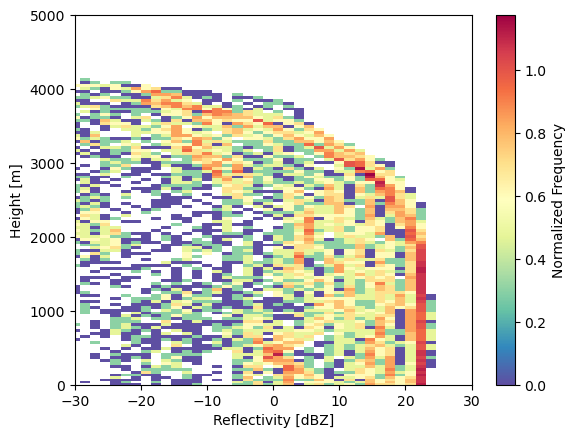

In [12]:
cfad_array = radtraq.plotting.calc_cfad(subcols.ds.sel(subcolumn=0), "sub_col_Ze_tot_strat",
                                        height_variable='hgt', xbins=np.linspace(-30., 30., 40))
cfad_array.plot(cmap='Spectral_r', cbar_kwargs=dict(label="Normalized Frequency"))
plt.xlim([-30, 30])
plt.xlabel('Reflectivity [dBZ]')
plt.ylabel('Height [m]')
plt.ylim([0, 5000])

## Plot KAZR observations

Now let's open up the KAZR observations for the simulated time period. In this case, we can just use xarray to open and view the dataset.

In [15]:
kazr_ds = xr.open_dataset('/data/project/ARM_Summer_School_2024_Data/emc2/anxkazrcfrgeqcM1.b1.20200313.180003.nc')
kazr_ds

<xarray.Dataset> Size: 38MB
Dimensions:                             (time: 1737, range: 600, frequency: 1,
                                         sweep: 1, r_calib: 1)
Coordinates:
  * time                                (time) datetime64[ns] 14kB 2020-03-13...
  * frequency                           (frequency) float32 4B 3.489e+10
  * range                               (range) float32 2kB 100.7 ... 1.806e+04
    azimuth                             (time) float32 7kB ...
    elevation                           (time) float32 7kB ...
Dimensions without coordinates: sweep, r_calib
Data variables: (12/38)
    base_time                           datetime64[ns] 8B ...
    time_offset                         (time) datetime64[ns] 14kB ...
    linear_depolarization_ratio         (time, range) float32 4MB ...
    mean_doppler_velocity               (time, range) float32 4MB ...
    mean_doppler_velocity_crosspolar_v  (time, range) float32 4MB ...
    reflectivity                        (time, range) float32 4MB ...
    ...                                  ...
    longitude                           float32 4B ...
    altitude                            float32 4B ...
    altitude_agl                        float32 4B ...
    lat                                 float32 4B ...
    lon                                 float32 4B ...
    alt                                 float32 4B ...
Attributes: (12/33)
    command_line:             kazrcfrqc -D 2 -s anx -f M1 -R -n kazrcfrgeqc -...
    Conventions:              ARM-1.2 CF/Radial-1.4 instrument_parameters rad...
    process_version:          ingest-kazrcfrqc-0.0-0.dev0.dirty.4.12.14-197.7...
    dod_version:              kazrcfrgeqc-b1-1.0
    input_source:             /data/collection/anx/anxkazrM1.00/KAZR_MOMENTS_...
    site_id:                  anx
    ...                       ...
    scan_name:                
    software_version:         1.7.6 (Wed Mar 23 17:10:35 UTC 2016 leachman
    title:                    ARM KAZR Moments B1
    transform_history:        Variable 'censor_mask' set as a bit mask.  SNR ...
    doi:                      10.5439/1478370
    history:                  created by user schuman on machine cirrus17.ccs...

Let's zoom into the simulated section! 

(0.0, 5000.0)

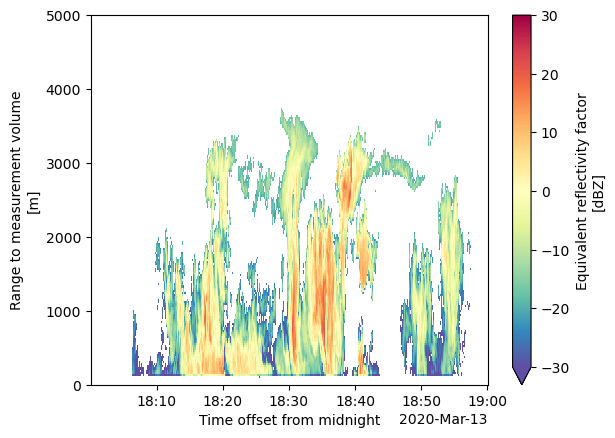

In [16]:
# Apply a SNR filter to filter out noise
kazr_ds = kazr_ds.where(kazr_ds['signal_to_noise_ratio_copolar_h'] > -10)

# Plot
kazr_ds['reflectivity'].T.plot(cmap='Spectral_r', vmin=-30, vmax=30)
plt.ylim([0, 5000])

Let's plot the CFADs side by side!

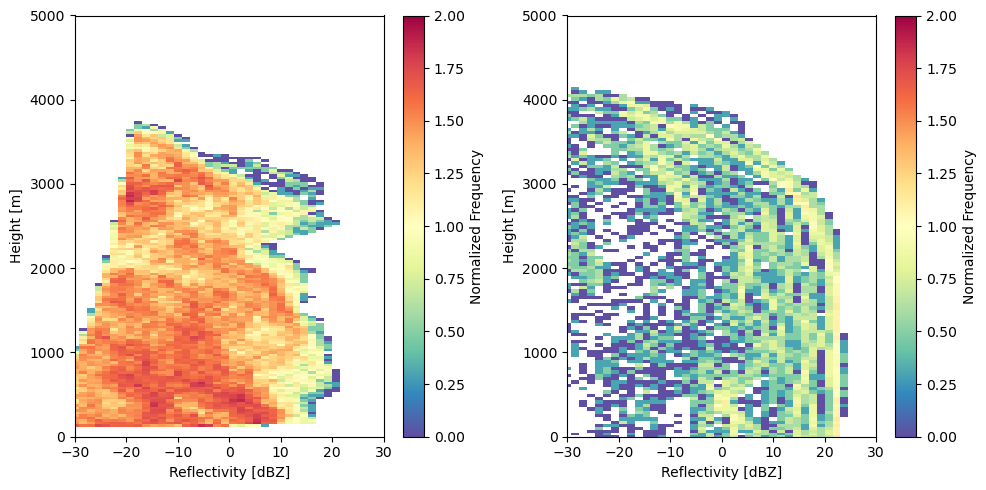

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
cfad_array = radtraq.plotting.calc_cfad(kazr_ds, "reflectivity",xbins=np.linspace(-30., 30., 40))
cfad_array.plot(cmap='Spectral_r', cbar_kwargs=dict(label="Normalized Frequency"), ax=ax[0], vmin=0, vmax=2)
cfad_model_array = radtraq.plotting.calc_cfad(subcols.ds.sel(subcolumn=0), "sub_col_Ze_tot_strat",
                                        height_variable='hgt', xbins=np.linspace(-30., 30., 40))
cfad_model_array.plot(cmap='Spectral_r', cbar_kwargs=dict(label="Normalized Frequency"), ax=ax[1], vmin=0, vmax=2)
ax[0].set_xlim([-30, 30])
ax[0].set_xlabel('Reflectivity [dBZ]')
ax[0].set_ylabel('Height [m]')
ax[0].set_ylim([0, 5000])
ax[1].set_xlim([-30, 30])
ax[1].set_xlabel('Reflectivity [dBZ]')
ax[1].set_ylabel('Height [m]')
ax[1].set_ylim([0, 5000])
fig.tight_layout()

## Second example -- WRF output

Here, the most intense precipitation is located at (-11 km, -8 km).

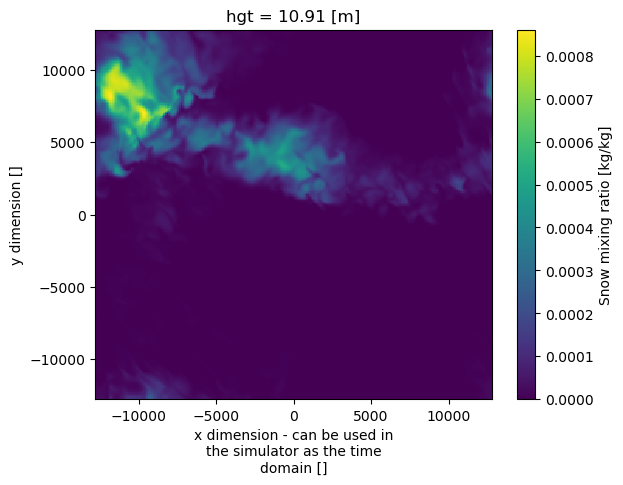

In [18]:
ds = xr.open_dataset("/data/project/ARM_Summer_School_2024_Data/emc2/emc2_prep_2020-03-13_18:00:00.nc")
ds["qpi"].isel(hgt=0).plot()

In [19]:
# Use DHARMA model since format/microphysics scheme are geared to that
WRF = emc2.core.model.DHARMA("emc2_prep_2020-03-13_18:00:00.nc", single_pi_class=False)

/ccsopen/proj/atm133/wrf/raw_output/emc2_prep_2020-03-13_18:00:00.nc is a regional output dataset; Stacking the time, lat, and lon dims for processing with EMC^2.


In [20]:
WRF.ds

<xarray.Dataset> Size: 2GB
Dimensions:         (hgt: 159, time_lat_lon: 65536, y_tmp: 256, x_tmp: 256,
                     dom_col_tmp: 1)
Coordinates:
  * hgt             (hgt) float64 1kB 10.91 35.45 65.42 ... 6.998e+03 7.052e+03
  * y_tmp           (y_tmp) float64 2kB -1.275e+04 -1.265e+04 ... 1.275e+04
  * x_tmp           (x_tmp) float64 2kB -1.275e+04 -1.265e+04 ... 1.275e+04
  * dom_col_tmp     (dom_col_tmp) int64 8B 0
  * time_lat_lon    (time_lat_lon) object 524kB MultiIndex
  * y               (time_lat_lon) float64 524kB -1.275e+04 ... 1.275e+04
  * x               (time_lat_lon) float64 524kB -1.275e+04 ... 1.275e+04
  * dom_col         (time_lat_lon) int64 524kB 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
Data variables: (12/28)
    z               (time_lat_lon, hgt) float64 83MB 10.89 35.37 ... 7.052e+03
    u_wind          (time_lat_lon, hgt) float64 83MB 2.668 2.983 ... 5.02 5.04
    v_wind          (time_lat_lon, hgt) float64 83MB -4.676 -5.128 ... -11.78
    w_wind          (time_lat_lon, hgt) float64 83MB 0.01613 ... 0.005641
    qcl             (time_lat_lon, hgt) float64 83MB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    qci             (time_lat_lon, hgt) float64 83MB 2.392e-07 2.189e-07 ... 0.0
    ...              ...
    strat_cl_frac   (time_lat_lon, hgt) float64 83MB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    strat_ci_frac   (time_lat_lon, hgt) float64 83MB 1.0 1.0 1.0 ... 0.0 0.0 0.0
    strat_pl_frac   (time_lat_lon, hgt) float64 83MB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    strat_pi_frac   (time_lat_lon, hgt) float64 83MB 1.0 1.0 1.0 ... 0.0 0.0 0.0
    strat_pir_frac  (time_lat_lon, hgt) float64 83MB 1.0 1.0 1.0 ... 0.0 0.0 0.0
    conv_dat        (time_lat_lon, hgt) float64 83MB 0.0 0.0 0.0 ... 0.0 0.0 0.0

Subset again!

In [21]:
u_mean = WRF.ds.u_wind.where(WRF.ds.hgt < 1000).mean()
v_mean = WRF.ds.v_wind.where(WRF.ds.hgt < 1000).mean()
slope = v_mean/u_mean
x0 = -11000
y0 = -8000
y_line = slope * (WRF.ds.x - x0) + y0 
WRF.ds["xsection"] = ('time_lat_lon', xr.where(np.isclose(y_line, WRF.ds.y, atol=50), 1, 0))
WRF.ds = WRF.ds.where(WRF.ds["xsection"] == 1).dropna(dim="time_lat_lon")
WRF.ds["distance"] = np.sqrt(
    (WRF.ds["y"] - WRF.ds["y"].values[0])**2 + (WRF.ds["x"] - WRF.ds["x"].values[0]))
WRF.ds = WRF.ds.set_coords(["distance", "hgt"])

Then we just repeat the same workflow over this dataset and add to the comparison.

In [22]:
KAZR = emc2.core.instruments.KAZR('nsa')
subcols_wrf = emc2.simulator.main.make_simulated_data(WRF, KAZR, 1, use_rad_logic=False)

## Creating subcolumns...
No convective processing for DHARMA
num_subcolumns == 1 (subcolumn generator turned off); setting subcolumns frac fields to 1 for startiform cl and ci based on q > 0. kg/kg
Done! total processing time = 0.00s
num_subcolumns == 1 (subcolumn generator turned off); setting subcolumns frac fields to 1 for strat precip based on q > 0. kg/kg
Done! total processing time = 0.00s
num_subcolumns == 1 (subcolumn generator turned off); setting subcolumns q (and N micro logic) fields for cl equal to grid-cell mean
num_subcolumns == 1 (subcolumn generator turned off); setting subcolumns q (and N micro logic) fields for ci equal to grid-cell mean
num_subcolumns == 1 (subcolumn generator turned off); setting subcolumns q (and N micro logic) fields for pl equal to grid-cell mean
num_subcolumns == 1 (subcolumn generator turned off); setting subcolumns q (and N micro logic) fields for pi equal to grid-cell mean
num_subcolumns == 1 (subcolumn generator turned off); setting subcol

Text(0.5, 0, 'Distance [m]')

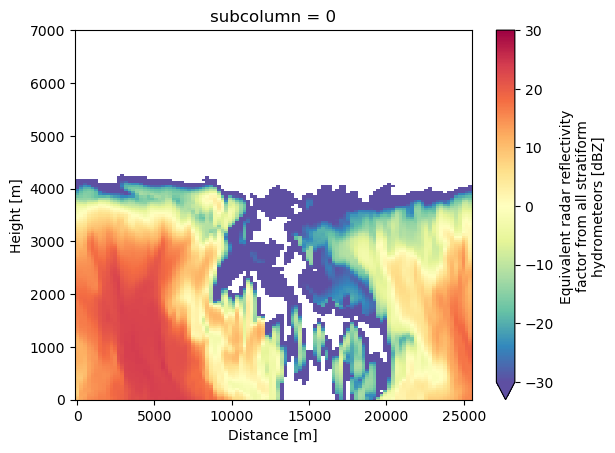

In [23]:
subcols.ds["sub_col_Ze_tot_strat"].sel(subcolumn=0).T.plot(vmin=-30, vmax=30, cmap='Spectral_r', x='distance', y='hgt')
plt.xlabel('Distance [m]')

Let's plot those CFADs again!

As we can see, there are major differences between the DHARMA, WRF, and KAZR observed profiles. However, for this demonstration, we were only able to compare small subsets of the domain against statistics from the observations. In addition, the 18 UTC time period is more anomalous compared to the rest of the dataset, which may skew these results. 

Comparisons of the full domain are left as an exercise for the student.

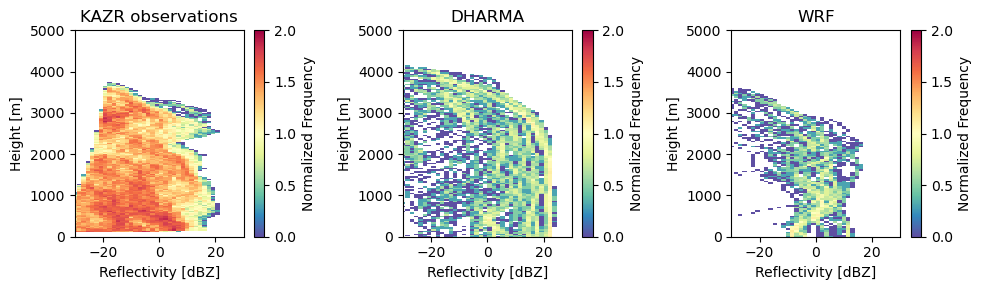

In [24]:
fig, ax = plt.subplots(1, 3, figsize=(10, 3))
cfad_array = radtraq.plotting.calc_cfad(kazr_ds, "reflectivity",xbins=np.linspace(-30., 30., 40))
cfad_array.plot(cmap='Spectral_r', cbar_kwargs=dict(label="Normalized Frequency"), ax=ax[0], vmin=0, vmax=2)
cfad_model_array = radtraq.plotting.calc_cfad(subcols.ds.sel(subcolumn=0), "sub_col_Ze_tot_strat",
                                        height_variable='hgt', xbins=np.linspace(-30., 30., 40))
cfad_model_array.plot(cmap='Spectral_r', cbar_kwargs=dict(label="Normalized Frequency"), ax=ax[1], vmin=0, vmax=2)
cfad_wrf_array = radtraq.plotting.calc_cfad(subcols_wrf.ds.sel(subcolumn=0), "sub_col_Ze_tot_strat",
                                        height_variable='hgt', xbins=np.linspace(-30., 30., 40))
cfad_wrf_array.plot(cmap='Spectral_r', cbar_kwargs=dict(label="Normalized Frequency"), ax=ax[2], vmin=0, vmax=2)
ax[0].set_xlim([-30, 30])
ax[0].set_xlabel('Reflectivity [dBZ]')
ax[0].set_ylabel('Height [m]')
ax[0].set_ylim([0, 5000])
ax[0].set_title('KAZR observations')
ax[1].set_xlim([-30, 30])
ax[1].set_xlabel('Reflectivity [dBZ]')
ax[1].set_ylabel('Height [m]')
ax[1].set_ylim([0, 5000])
ax[1].set_title('DHARMA')
ax[2].set_xlim([-30, 30])
ax[2].set_xlabel('Reflectivity [dBZ]')
ax[2].set_ylabel('Height [m]')
ax[2].set_ylim([0, 5000])
ax[2].set_title('WRF')
fig.tight_layout()
fig.savefig('cfads.png')

## Full domain comparison -- dask requirement

In order to enable parallel processing in EMC^2 for quicker calclation of the full domain, you will need to run this line to enable the dask multiprocessing on the cluster before starting the above code. This creates a local dask cluster on the machine for parallel computation with three workers. For this example, you may need more workers to process the full domain.

In [ ]:
from dask.distributed import LocalCluster, Client
client = Client(LocalCluster(n_workers=3))

In addition, another tip to process the full domain would be to subset the domain into 4-16 rectangular portions then concatenatethe results. To process only one subset of the domain, use the xarray .sel operator to do so in this fashion. This code will process the bottom left portion of the domain. Expanding this code and concatenating the results is left as an exercise for the student. 

In [ ]:
ds = xr.open_dataset('/data/project/ARM_Summer_School_2024_Data/emc2/emc2_prep.nc')
dharma = emc2.core.model.DHARMA('/data/project/ARM_Summer_School_2024_Data/emc2/emc2_prep.nc', single_pi_class=False)
dharma.ds = ds.sel(x=slice(-12500., 0), y=slice(-12500., 0.)) 
dharma.ds = dharma.ds.stack(time_lat_lon=["x", "y"])
KAZR = emc2.core.instruments.KAZR('nsa')
subcols_dharma = emc2.simulator.main.make_simulated_data(dharma, KAZR, 1, use_rad_logic=False)